In [29]:
from pathlib import Path
from tqdm import tqdm
import napari
import tifffile
import numpy as np
from apoc import ObjectSegmenter
import os 
import matplotlib.pyplot as plt
import apoc
from scipy.ndimage import binary_erosion, binary_dilation
import pyclesperanto_prototype as cle

In [30]:
directory_path = Path("./raw_data/")
images = []

# Iterate through the lsm files in the directory
for file_path in directory_path.glob("*.lsm"):
    images.append(str(file_path))
    
images

['raw_data\\DSB Iba1 16_40X_CA1.lsm',
 'raw_data\\DSB Iba1 16_40X_CA3.lsm',
 'raw_data\\DSB Iba1 16_40X_CTX1.lsm',
 'raw_data\\DSB Iba1 16_40X_CTX2.lsm',
 'raw_data\\DSB Iba1 16_40X_CTX3.lsm',
 'raw_data\\DSB Iba1 16_40X_DG.lsm',
 'raw_data\\DSB Iba1 17_40X_CA1.lsm',
 'raw_data\\DSB Iba1 17_40X_CA3.lsm',
 'raw_data\\DSB Iba1 17_40X_CTX1.lsm',
 'raw_data\\DSB Iba1 17_40X_CTX2.lsm',
 'raw_data\\DSB Iba1 17_40X_CTX3.lsm',
 'raw_data\\DSB Iba1 17_40X_DG.lsm',
 'raw_data\\DSB Iba1 18_40X_CA1.lsm',
 'raw_data\\DSB Iba1 18_40X_CA3.lsm',
 'raw_data\\DSB Iba1 18_40X_CTX1.lsm',
 'raw_data\\DSB Iba1 18_40X_CTX2.lsm',
 'raw_data\\DSB Iba1 18_40X_CTX3.lsm',
 'raw_data\\DSB Iba1 18_40X_DG.lsm',
 'raw_data\\DSB Iba1 19_40X_CA1.lsm',
 'raw_data\\DSB Iba1 19_40X_CA3.lsm',
 'raw_data\\DSB Iba1 19_40X_CTX1.lsm',
 'raw_data\\DSB Iba1 19_40X_CTX2.lsm',
 'raw_data\\DSB Iba1 19_40X_CTX3.lsm',
 'raw_data\\DSB Iba1 19_40X_DG.lsm',
 'raw_data\\DSB Iba1 20_40X_CA1.lsm',
 'raw_data\\DSB Iba1 20_40X_CA3.lsm',
 'ra

In [31]:
# Define the images that will be used for training and validation
# train_index = [36, 37, 42, 34, 48, 39, 55, 58, 69, 76, 152, 100, 117, 124, 125, 24, 25, 162]

# Define input folders for training
image_folder = Path("./dna_damage_train_data/images/")
masks_folder = Path("./dna_damage_train_data/masks/")

# Create the necessary folder structure if it does not exist
try:
    os.makedirs(str(image_folder))
    os.makedirs(str(masks_folder))
    print(f"Output folder created: {image_folder}")
    print(f"Output folder created: {masks_folder}")
except FileExistsError:
    print(f"Output folder already exists: {image_folder}")
    print(f"Output folder already exists: {masks_folder}")

Output folder already exists: dna_damage_train_data\images
Output folder already exists: dna_damage_train_data\masks


In [32]:
# Extract the dna_damage maximum intensity projections that will be used for training and store them under ./dna_damage_train_data/images
# Remove comments to run from raw_data. Images used for training are already in the repo
# viewer = napari.Viewer(ndisplay=2)

# for index in train_index:
    
#     image = images[index]
    
#     # Extract filename
#     file_path = Path(image)
#     filename = file_path.stem

#     # Read the image file 
#     img = tifffile.imread(image)

#     # Extract the stack containing the dna_damage (1) 
#     dna_damage_stack = img[:,1,:,:]

#     # Perform maximum intensity projections
#     dna_damage_mip = np.max(dna_damage_stack, axis=0)
    
#     # Save a .tiff copy of dna_damage_mip
#     tifffile.imwrite(os.path.join(image_folder, f"{filename}.tiff"), dna_damage_mip, dtype="uint8")

#     # Show the resulting mip in Napari for sparse label annotation
#     viewer.add_image(dna_damage_mip, name=f"{filename}_dna_damage")


Display the images used for training and the sparse ground truth annotation 

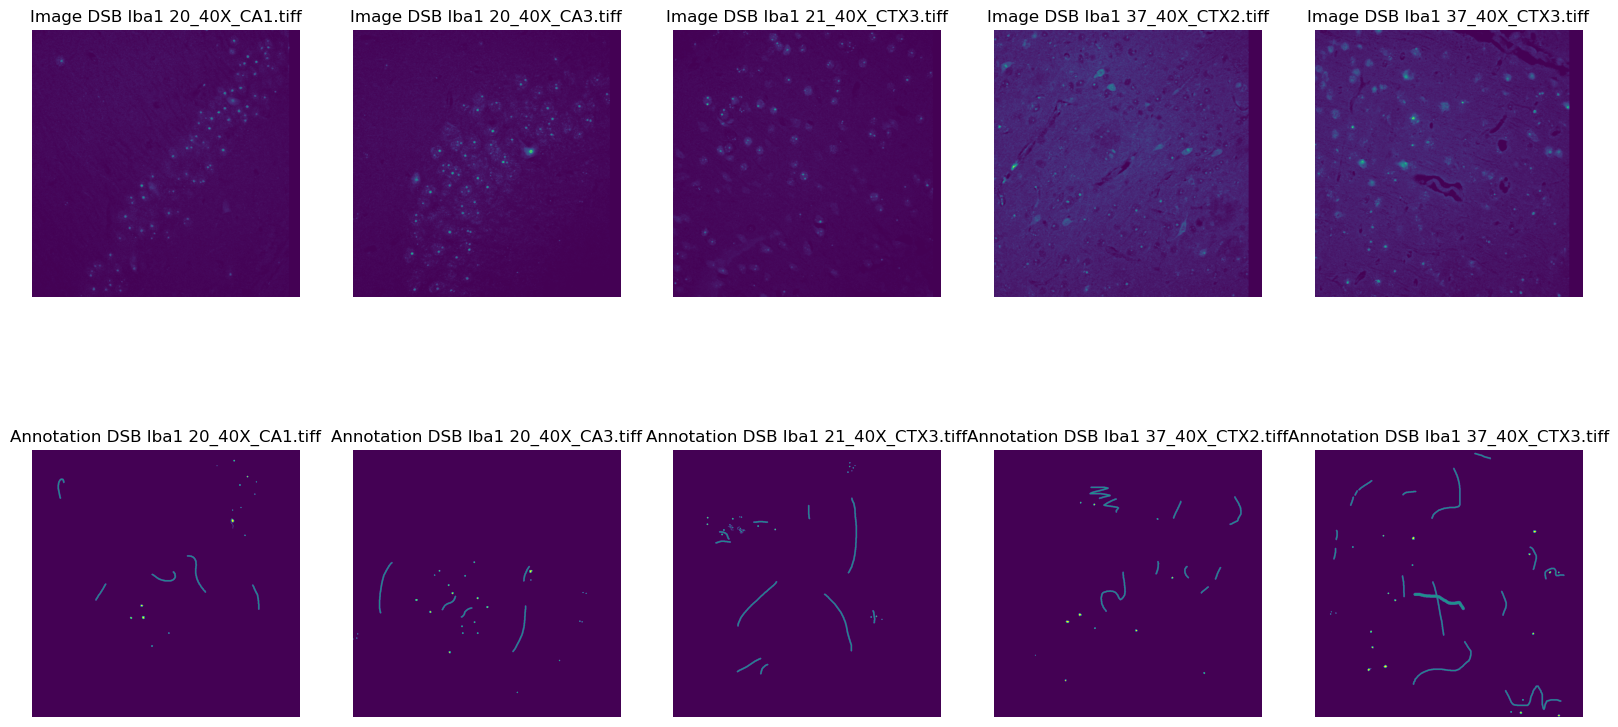

In [33]:
# Get the list of file names in the images and masks folder
image_file_list = [file_path.name for file_path in image_folder.glob("*.tiff")]
masks_file_list = [file_path.name for file_path in masks_folder.glob("*.tiff")]

# Ensure the masks folder has the same number of files as the images folder
# assert len(image_file_list) == len(masks_file_list), "Number of images and masks must be the same."

# Show images and corresponding masks side by side
num_images = len(image_file_list)
fig, axs = plt.subplots(2, num_images, figsize=(4 * num_images, 10))

for i, (image_filename, mask_filename) in enumerate(zip(image_file_list, masks_file_list)):
    # Plot the image
    image = tifffile.imread(os.path.join(image_folder, image_filename))
    axs[0, i].imshow(image)
    axs[0, i].axis("off")
    axs[0, i].set_title(f"Image {image_filename}")

    # Plot the corresponding mask
    mask = tifffile.imread(os.path.join(masks_folder, mask_filename))
    axs[1, i].imshow(mask, cmap="viridis")  # Use cmap='viridis' for multinary masks
    axs[1, i].axis("off")
    axs[1, i].set_title(f"Annotation {mask_filename}")
    
plt.show()

## Training
If the folders are setup properly, we can pass the folders to the training.

In [34]:
# Setup classifer and where it should be saved
cl_filename = "./object_segmenters/dna_damage_object_segmenter_v3.cl"
apoc.erase_classifier(cl_filename)
segmenter = apoc.ObjectSegmenter(opencl_filename=cl_filename)

# Setup feature set used for training
features = apoc.PredefinedFeatureSet.object_size_1_to_5_px.value #TODO: Check

# Train classifier on folders
apoc.train_classifier_from_image_folders(
    segmenter, 
    features, 
    image = image_folder, # Grayscale processed images, no RGB
    ground_truth = masks_folder)

## Prediction
After the training, we can apply the classifier to all images in the dna_damage_train_ data image folder. The following line reloads the classifier from disk. In that way we can ensure that it was stored correctly. Afterwards, we will apply an erosion and dilation cycle to explore how the resulting DNA damage mask look after removal of small artifacts. We do so using a binary erosion/dilation or a .cle label based erosion/dilation, then we can compare the results. The .cle based one is more restrictive and we lose some dna_damage foci we are interested in quantifying, we will stick with the scipy.ndimage binary erosion/dilation for the batch image analysis

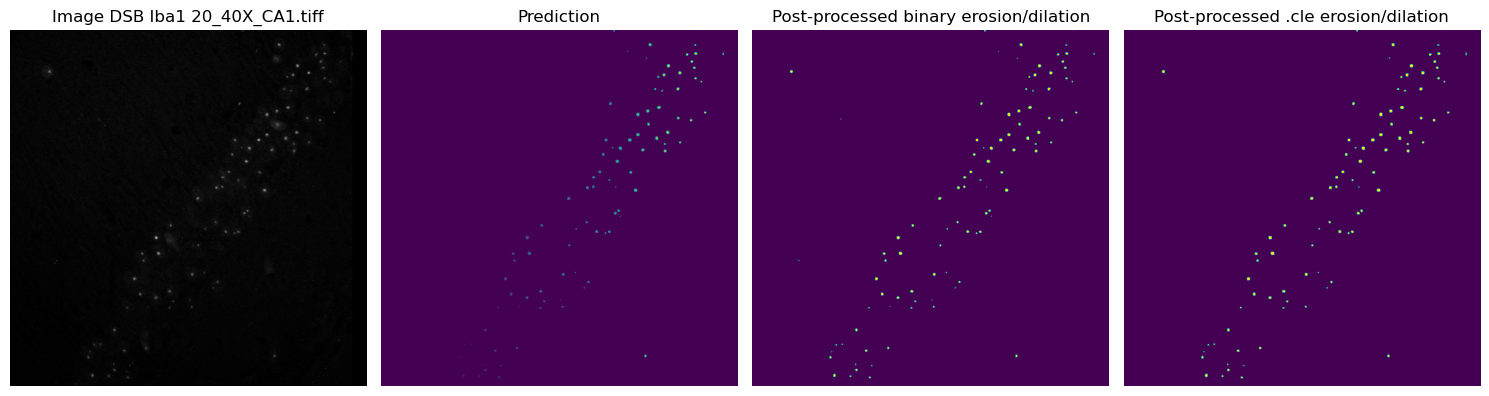

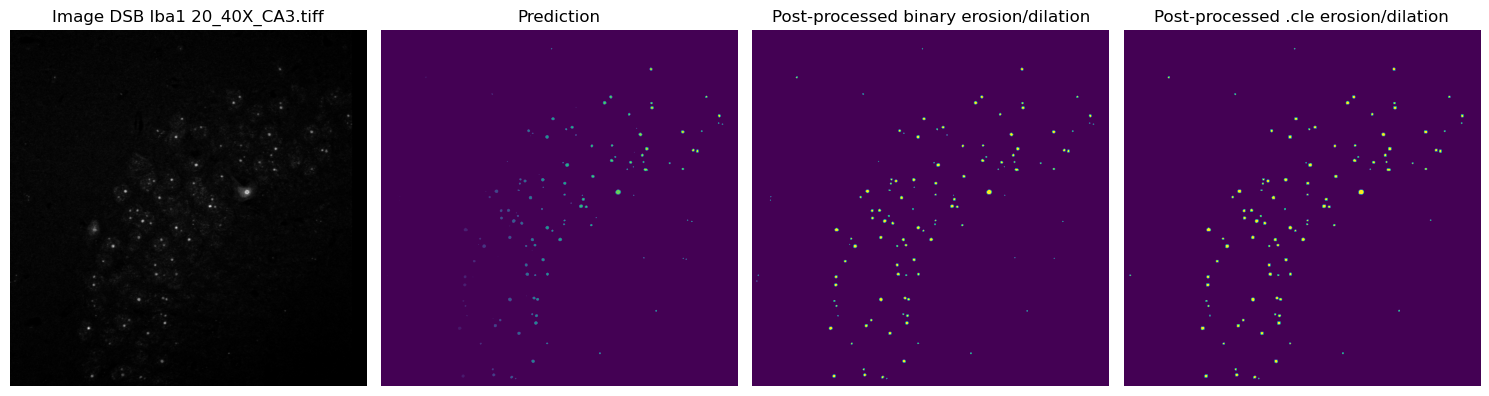

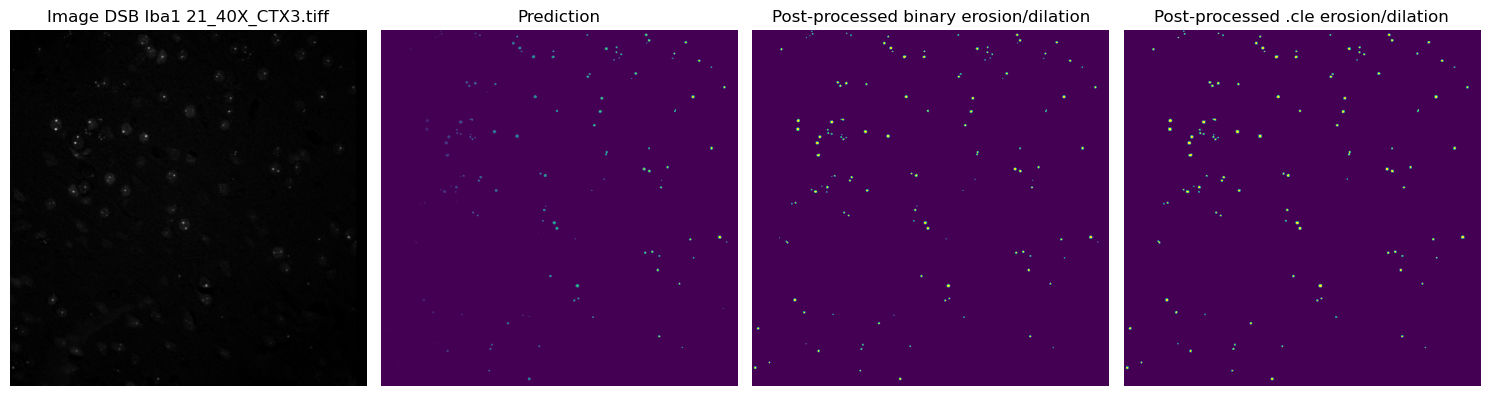

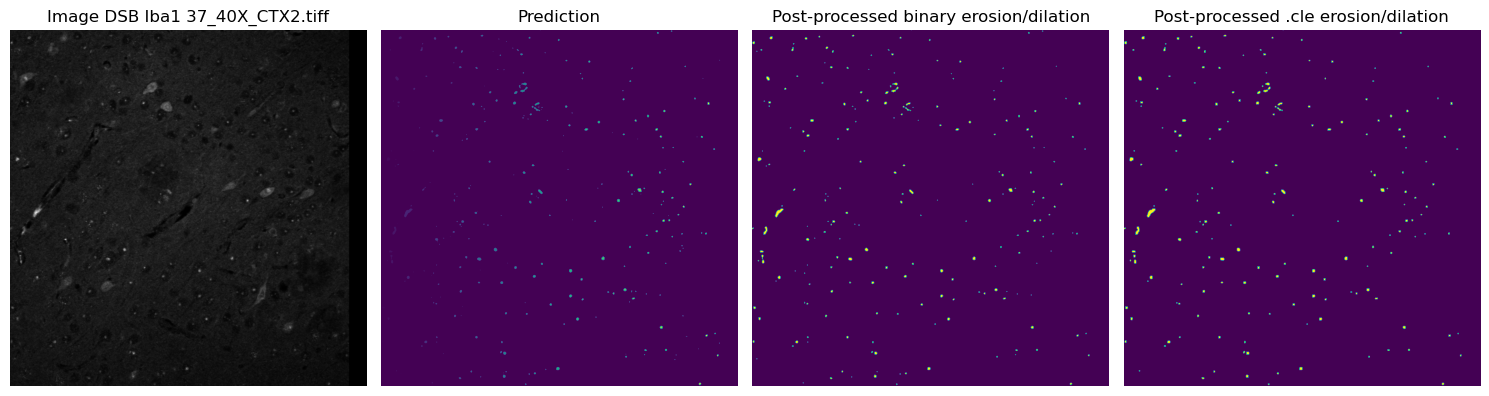

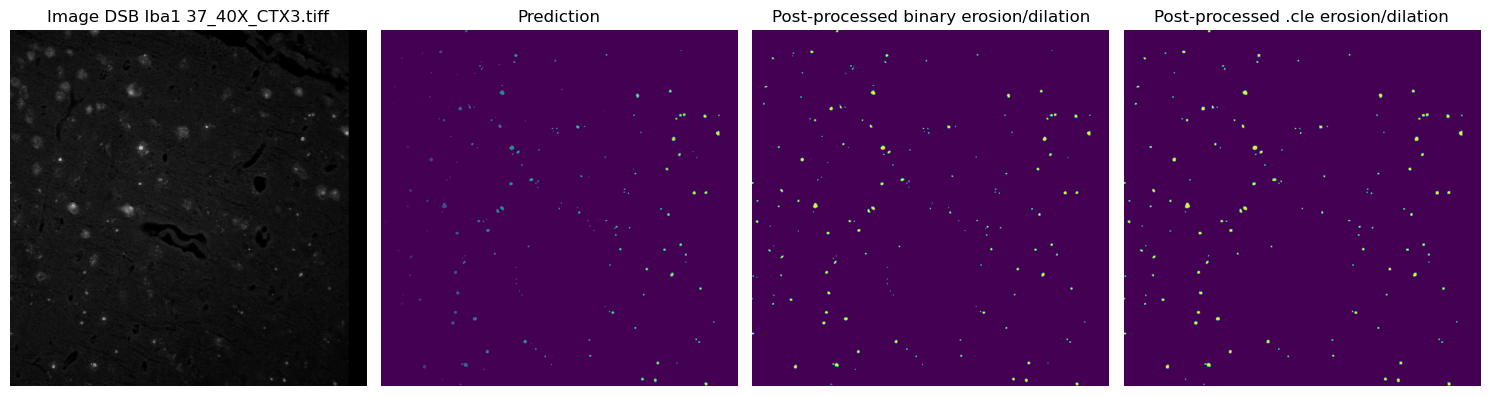

In [35]:
viewer = napari.Viewer(ndisplay=2)
segmenter = apoc.ObjectSegmenter(opencl_filename=cl_filename)
image_file_list = [file_path.name for file_path in image_folder.glob("*.tiff")]

for image_filename in image_file_list:
    
    fig, axs = plt.subplots(1, 4, figsize=(15, 15))  # Adjust the subplot to 2x2
    
    # Read the image
    image = tifffile.imread(os.path.join(image_folder, image_filename), is_ome=False)
    axs[0].imshow(image, cmap="gray")
    axs[0].axis("off")
    axs[0].set_title(f"Image {image_filename}")
    
    # Predict labels
    predicted_labels = segmenter.predict(image)
    axs[1].imshow(predicted_labels, cmap='viridis')
    axs[1].axis("off")
    axs[1].set_title(f"Prediction")
    
    # Binary erosion and dilation post-processing
    structuring_element_damage = np.ones((2, 2), dtype=bool)
    eroded_dna_damage = binary_erosion(predicted_labels, structure=structuring_element_damage)
    dilated_dna_damage = binary_dilation(eroded_dna_damage, structure=structuring_element_damage)
    axs[2].imshow(dilated_dna_damage, cmap='viridis')
    axs[2].axis("off")
    axs[2].set_title(f"Post-processed binary erosion/dilation")
    
    # .cle erosion and dilation post-processing
    cle_eroded_dna_damage = cle.erode_labels(predicted_labels, radius=1)
    cle_dilated_dna_damage = cle.dilate_labels(cle_eroded_dna_damage, radius=1)
    # Transform cle_dilated_dna_damage into a boolean array
    cle_dilated_dna_damage = cle_dilated_dna_damage > 0
    axs[3].imshow(cle_dilated_dna_damage, cmap='viridis')
    axs[3].axis("off")
    axs[3].set_title(f"Post-processed .cle erosion/dilation")
    
    # Show the resulting dna_damage in Napari
    viewer.add_image(image, name=f"{image_filename}_dnad_input")
    viewer.add_labels(predicted_labels, name=f"{image_filename}_apoc_prediction")
    viewer.add_labels(dilated_dna_damage, name=f"{image_filename}_binary_ero_dil")
    viewer.add_labels(cle_dilated_dna_damage, name=f"{image_filename}_.cle_ero_dil")
    
    plt.tight_layout()
    plt.show()

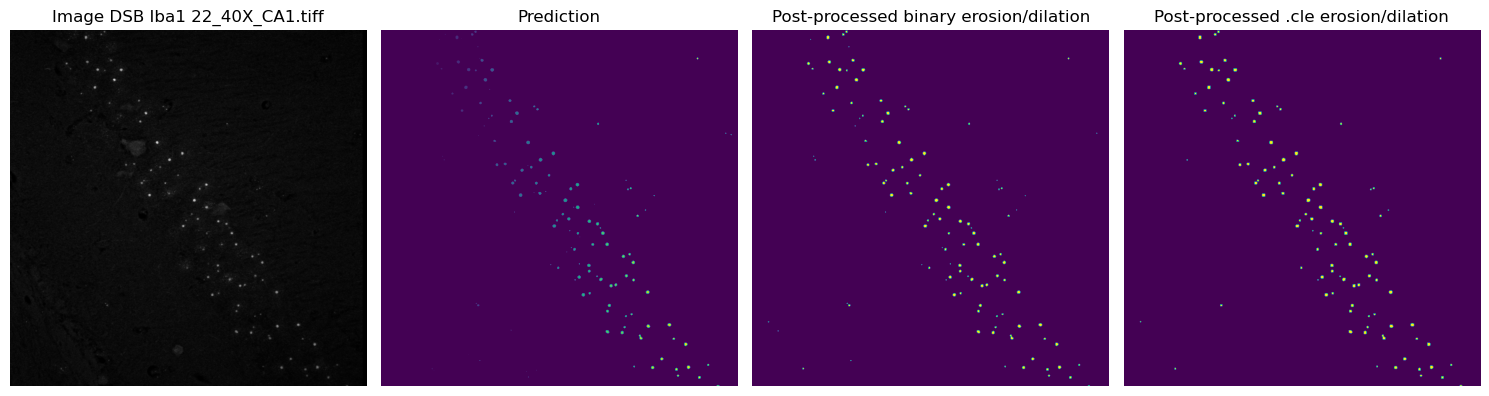

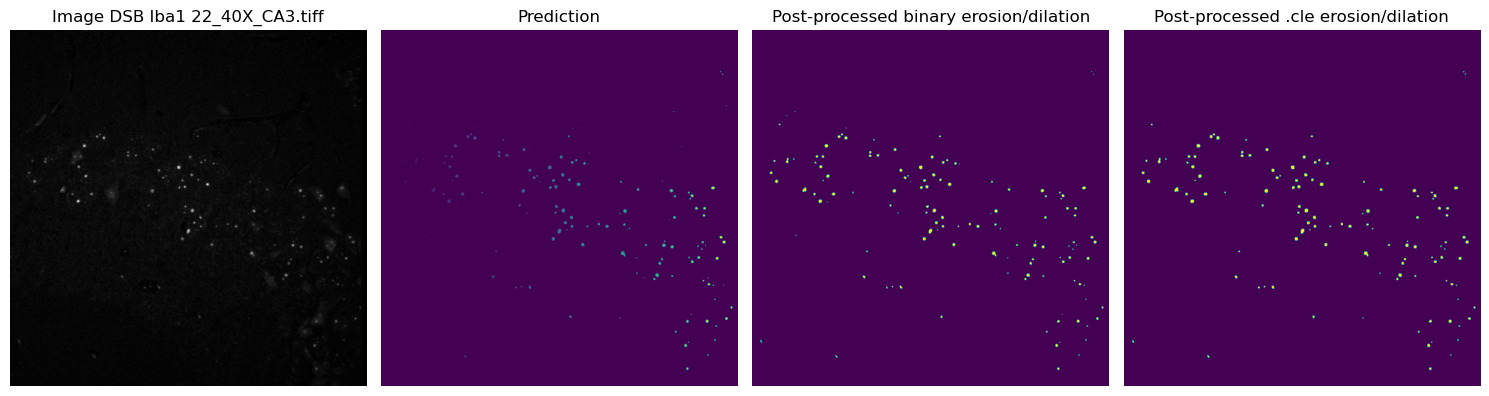

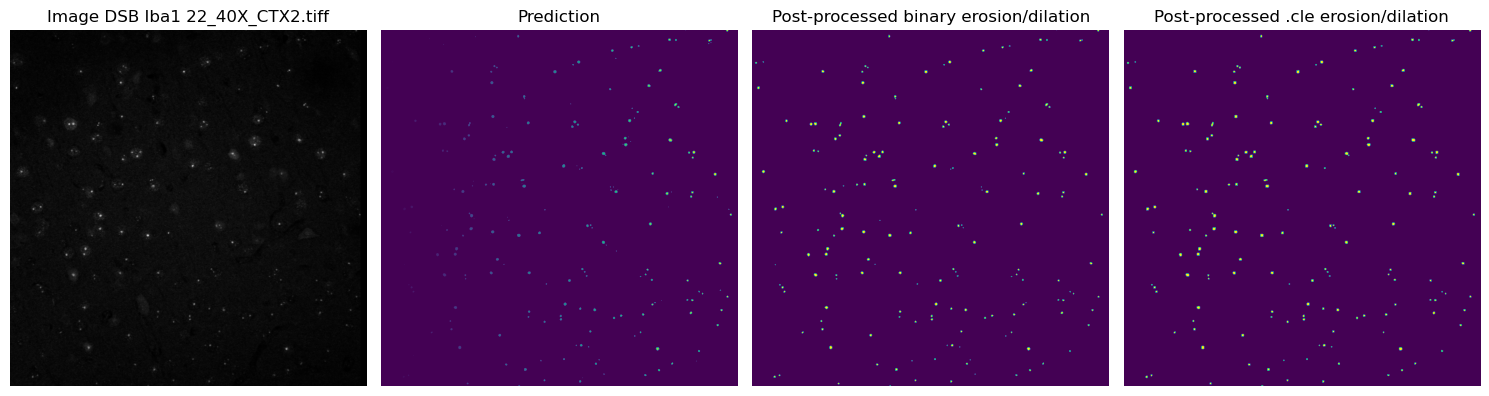

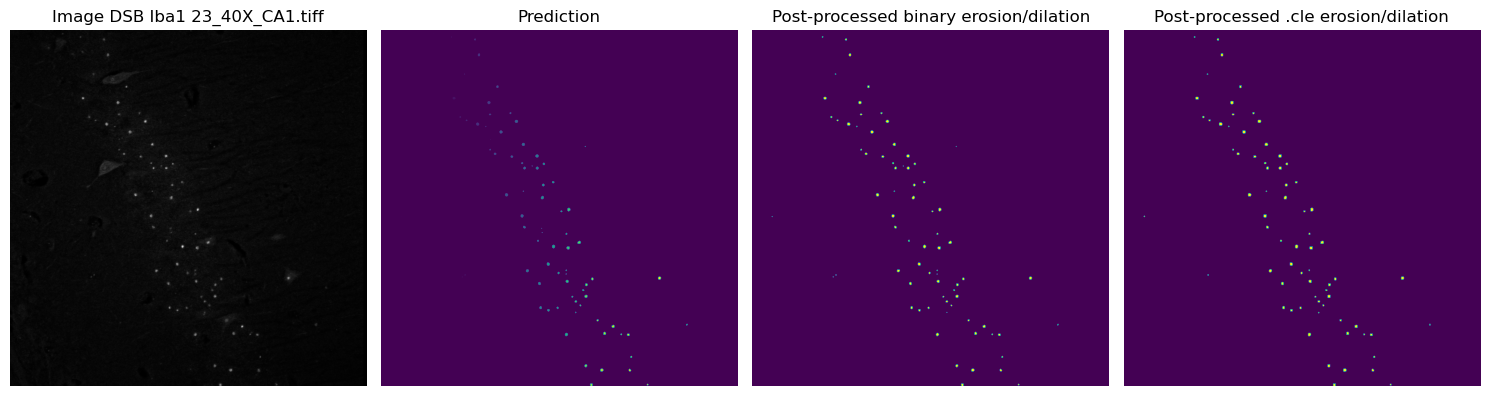

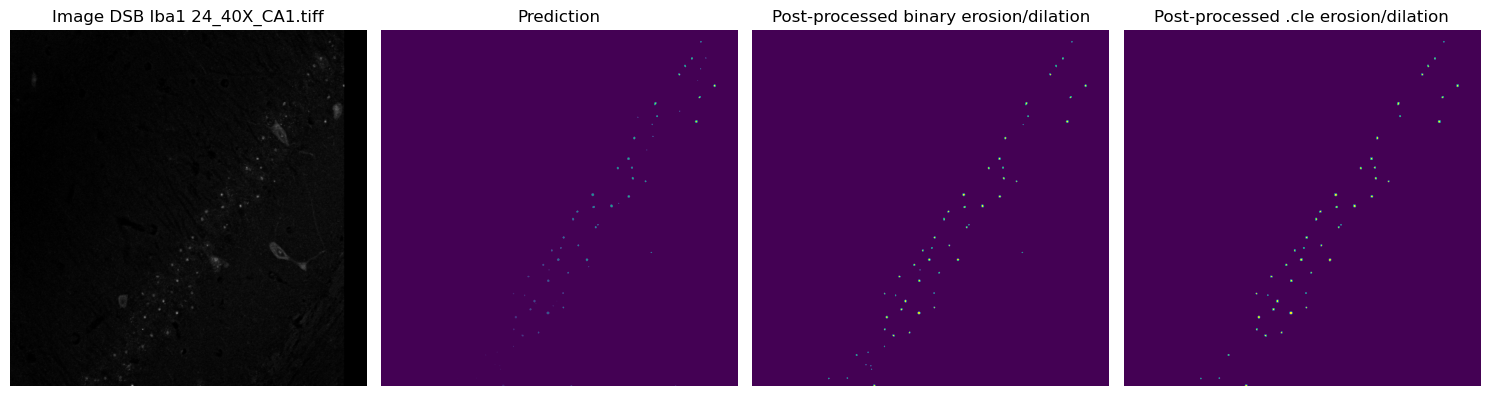

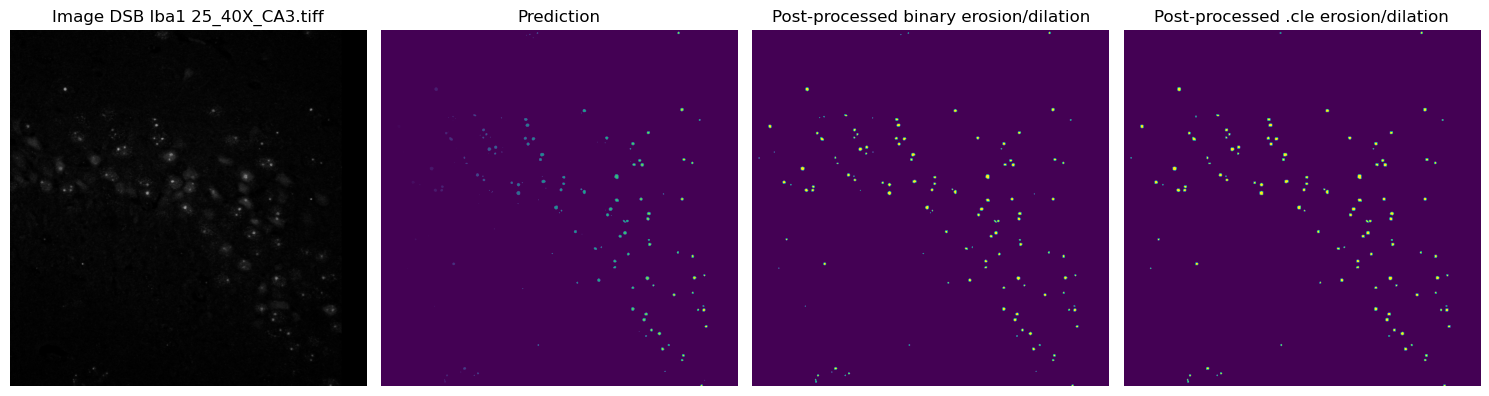

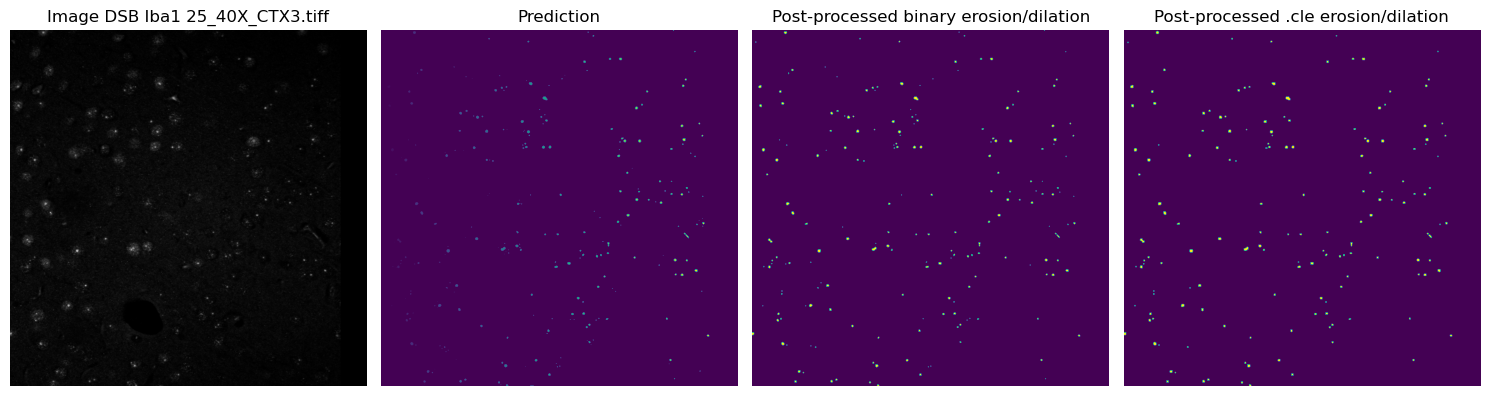

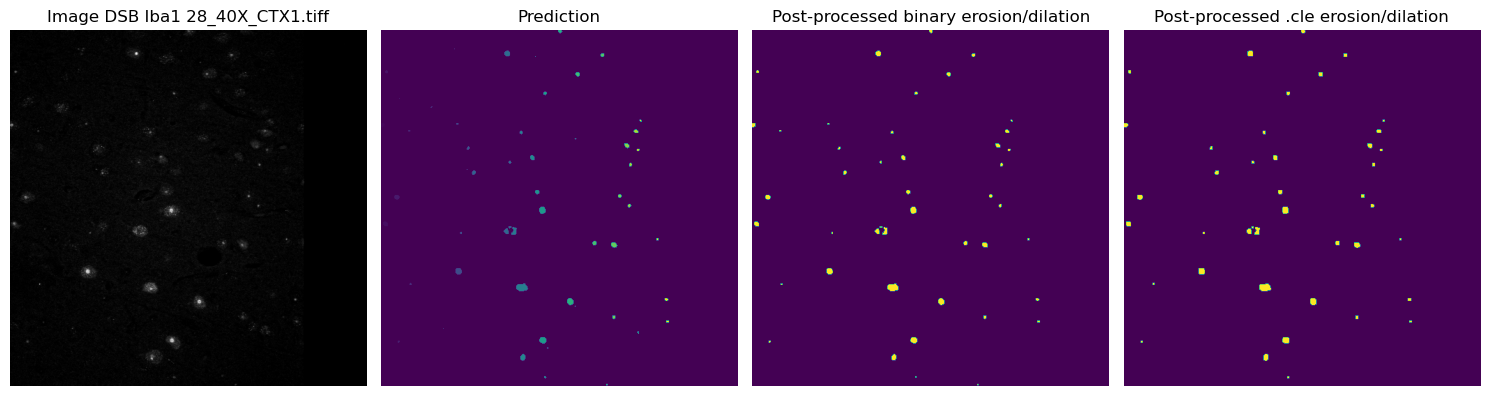

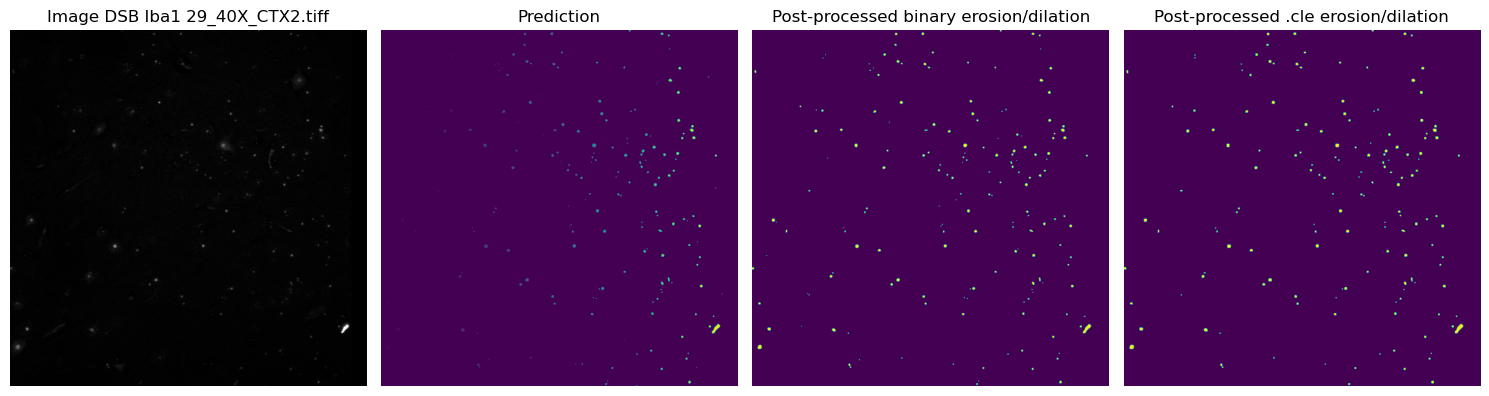

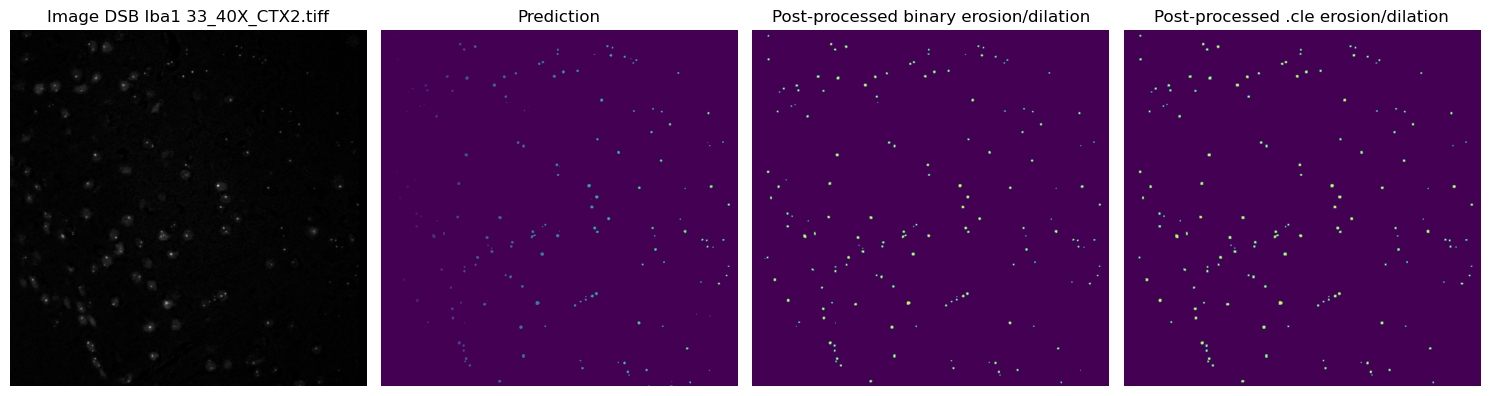

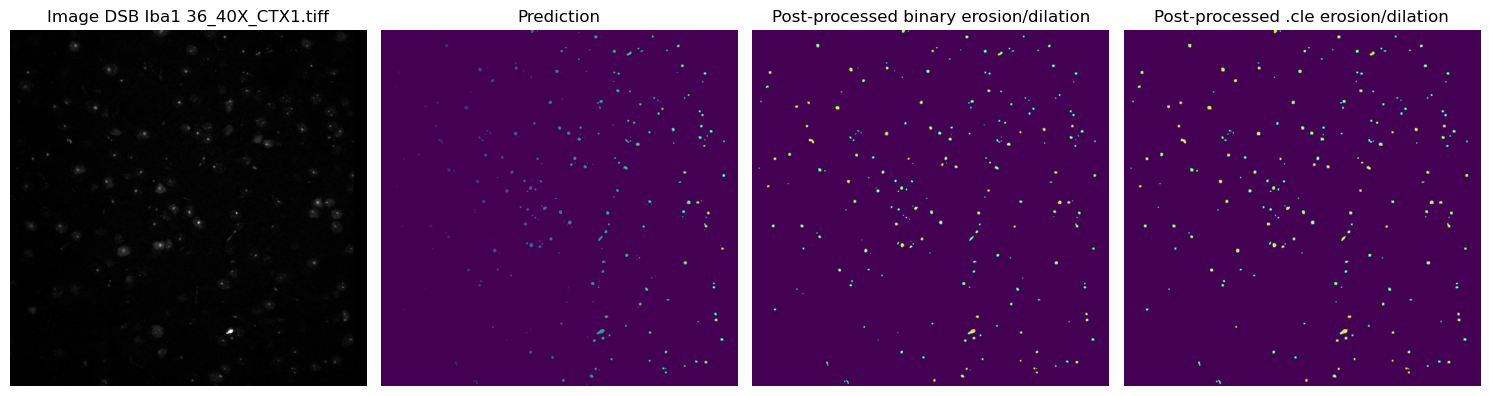

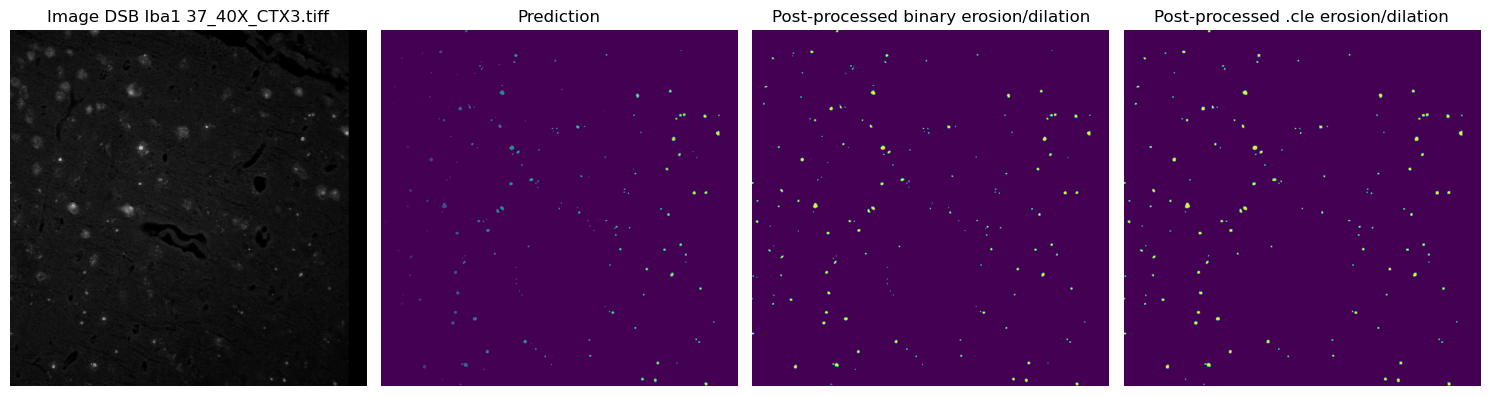

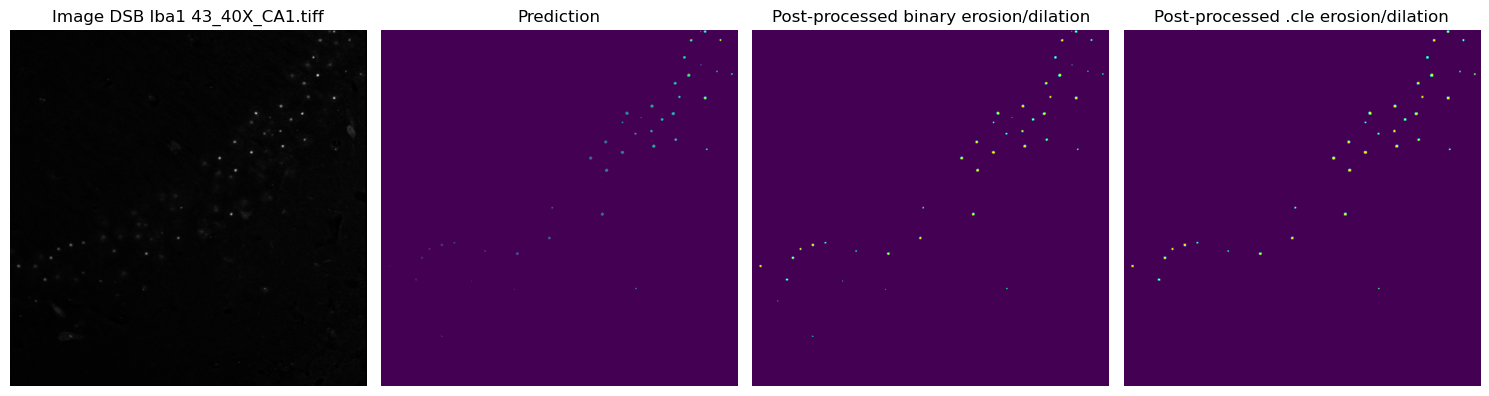

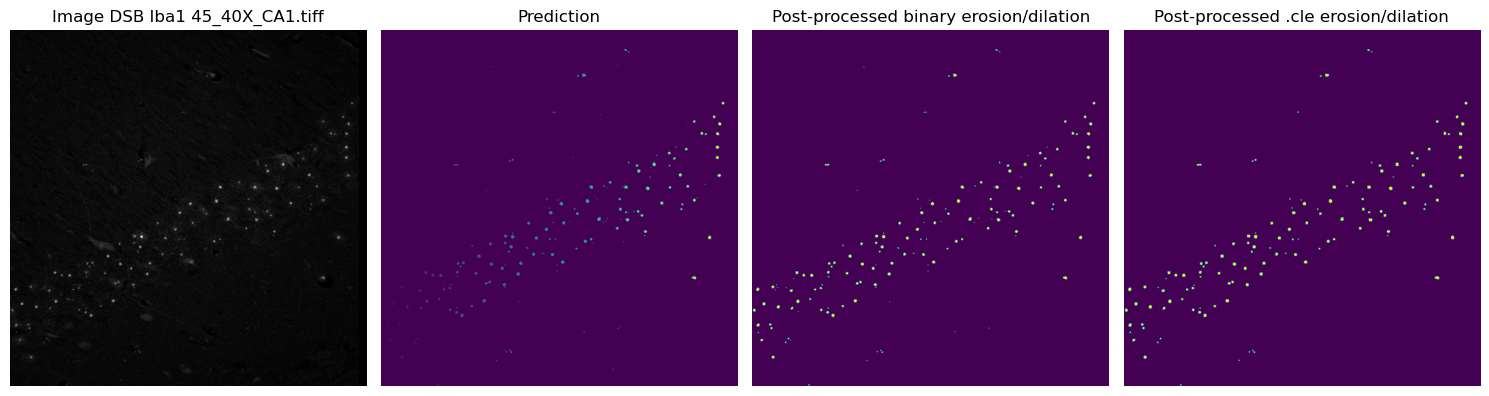

In [36]:
# Define input folders for validation
image_folder = Path("./dna_damage_train_data/validation_images/")

viewer = napari.Viewer(ndisplay=2)
segmenter = apoc.ObjectSegmenter(opencl_filename=cl_filename)
image_file_list = [file_path.name for file_path in image_folder.glob("*.tiff")]

for image_filename in image_file_list:
    
    fig, axs = plt.subplots(1, 4, figsize=(15, 15))  # Adjust the subplot to 2x2
    
    # Read the image
    image = tifffile.imread(os.path.join(image_folder, image_filename), is_ome=False)
    axs[0].imshow(image, cmap="gray")
    axs[0].axis("off")
    axs[0].set_title(f"Image {image_filename}")
    
    # Predict labels
    predicted_labels = segmenter.predict(image)
    axs[1].imshow(predicted_labels, cmap='viridis')
    axs[1].axis("off")
    axs[1].set_title(f"Prediction")
    
    # Binary erosion and dilation post-processing
    structuring_element_damage = np.ones((2, 2), dtype=bool)
    eroded_dna_damage = binary_erosion(predicted_labels, structure=structuring_element_damage)
    dilated_dna_damage = binary_dilation(eroded_dna_damage, structure=structuring_element_damage)
    axs[2].imshow(dilated_dna_damage, cmap='viridis')
    axs[2].axis("off")
    axs[2].set_title(f"Post-processed binary erosion/dilation")
    
    # .cle erosion and dilation post-processing
    cle_eroded_dna_damage = cle.erode_labels(predicted_labels, radius=1)
    cle_dilated_dna_damage = cle.dilate_labels(cle_eroded_dna_damage, radius=1)
    # Transform cle_dilated_dna_damage into a boolean array
    cle_dilated_dna_damage = cle_dilated_dna_damage > 0
    axs[3].imshow(cle_dilated_dna_damage, cmap='viridis')
    axs[3].axis("off")
    axs[3].set_title(f"Post-processed .cle erosion/dilation")
    
    # Show the resulting dna_damage in Napari
    viewer.add_image(image, name=f"{image_filename}_dnad_input")
    viewer.add_labels(predicted_labels, name=f"{image_filename}_apoc_prediction")
    viewer.add_labels(dilated_dna_damage, name=f"{image_filename}_binary_ero_dil")
    viewer.add_labels(cle_dilated_dna_damage, name=f"{image_filename}_.cle_ero_dil")
    
    plt.tight_layout()
    plt.show()